# GA

### AFElSamak_2015_AffinityPropagationClustering_GA
###### AHussain_2017_GA_ModifiedCycleCrossover => Cycle Crossover (CX)
###### ARiazi_2019_GA_Double‐Chromosome => (X) IDK
###### CWTsai_2014_High-PerformanceGA => Common Genes Detection, Compression (Good)
###### JWang_2016_Multi-offspringGA (medium-scale) => (?already) Multi-Offspring
###### SDDao_2016_EffectiveGA (Large-Scale TSP) => Initial Chromosome Strategy (Maybe Good)
###### YDeng_2015_ImprovedGA_InitialPopulationStrategy => K-Means Clustering (...)
###### YWang_2014_HybridGA_TwoLocalOptStrategies => (X) 4 vertices 3 lines inequality

Common Genes Detection & Compression, Initial Chromosome Strategy, K-Means Cluster

In [1]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

In [2]:
# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

## Data Loading

In [3]:
def fileloader():
    with open(file_path, "r") as file:
        file_str = file.readlines()
    
    coord_start_idx = 8
    for line in range(2,len(file_str)-1):
        if 'NODE_COORD_SECTION' in file_str[line]:
            coord_start_idx = line + 1
    # Get the coordinates of cities
    coord_str = file_str[coord_start_idx:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = float(items[1]), float(items[2])

    return coord_list

## Improved GA

In [244]:
# Global Variables
FIRST_IDX = 0
# GA
INITIAL_POOL_SIZE = 3
MAXIMUM_POOL_SIZE = 50
# POOL_SIZE = 20
# TOURNAMENT_SIZE = POOL_SIZE//2
MAX_ITERATION = 100000

# # SA
# ### modified due to time constraint ###
# MAX_EVALUATION = 2
# SUB_ITERATIONS = 2
# TEMPERATURE = 2
# COOLING_RATIO = 0.3
# TEMP_LIMIT = 1

In [245]:
def initialize_greedy(coord_list, path_map):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = FIRST_IDX, FIRST_IDX

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[FIRST_IDX] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path

def initialize_innovative(x_coord_sorted, y_coord_sorted, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = FIRST_IDX, FIRST_IDX
    path[1] = first_idx
    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[FIRST_IDX] = False
    cities_tovisit[first_idx] = False
    for i in range(2, cnt_cities-1):
        
        if path[i]!=0:
            continue
        
        x_idx = np.where(x_coord_sorted == path[i-1])[0][0]
        y_idx = np.where(y_coord_sorted == path[i-1])[0][0]
        
        for j in range(1, cnt_cities):
            
            x_segment = np.concatenate([
                x_coord_sorted[max(1, x_idx-j):x_idx], 
                x_coord_sorted[x_idx+1:min(x_idx+j+1,cnt_cities+1)]
            ])
            y_segment = np.concatenate([
                y_coord_sorted[max(1, y_idx-j):y_idx], 
                y_coord_sorted[y_idx+1:min(y_idx+j+1,cnt_cities+1)]
            ])
            
            common_cities = []
            
            if cities_tovisit[x_segment[0]]:
                if x_segment[0] in y_segment:
                    common_cities.append(x_segment[0])
                    
            if cities_tovisit[x_segment[-1]]:
                if x_segment[-1] in y_segment:
                    common_cities.append(x_segment[-1])
                    
            if cities_tovisit[y_segment[0]]:
                if y_segment[0] in x_segment:
                    common_cities.append(y_segment[0])
                    
            if cities_tovisit[y_segment[-1]]:
                if y_segment[-1] in x_segment:
                    common_cities.append(y_segment[-1])
            
            common_cities = list(set(common_cities))
            common_count = len(common_cities)
            
            if common_count > 0:
                common_cities = np.array(common_cities)
                cities_tovisit[common_cities] = False
                np.random.shuffle(common_cities)
                path[i:i+common_count] = common_cities
                break
                
    path[-2] = np.where(cities_tovisit)[0][0]
    return path

def initialize_random(coord_list):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)

    path[0], path[-1] = FIRST_IDX, FIRST_IDX

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), FIRST_IDX)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path

def path_cost(path_map, path, subpath_dict={}):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        while path[i+1]<-1:
            path = np.concatenate([path[:i+1], subpath_dict[path[i+1]], path[i+2:]])
        cost_arr[i] = path_map[path[i], path[i+1]]
    return cost_arr

In [246]:
# def two_opt_swap(path_map, path, iterations, coord_list):
#     cnt_cities = path_map.shape[0]
#     # Save the best path

#     cost_arr = path_cost(path_map, path)
#     best_path = path.copy()
#     best_cost = cost_arr.sum()
    
#     for i in range(iterations):
#         curr_path = best_path.copy()
#         # Select two indices of flip points
#         sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

#         # Path Flip and update cost array
#         curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
#         cost_arr = path_cost(path_map, curr_path)

#         # Compare to the best path
#         curr_cost = cost_arr.sum()
#         if curr_cost < best_cost:
#             best_path = curr_path
#             best_cost = curr_cost
    
#     temperature = TEMPERATURE
#     while temperature > TEMP_LIMIT:
#         curr_path = best_path.copy()
#         # Select two indices of flip points
#         sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

#         # Path Flip and update cost array
#         curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
#         cost_arr = path_cost(path_map, curr_path)
#         curr_cost = cost_arr.sum()

#         if curr_cost <= best_cost:
#             best_path, best_cost = curr_path, curr_cost
#         else:
#             prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
#             if prob > np.random.rand(1):
#                 best_path, best_cost = curr_path, curr_cost
#         temperature = temperature * COOLING_RATIO 
#     return best_path, best_cost

In [247]:
# def sa(path_map, path, coord_list):
#     best_path, best_cost = path.copy() , path_cost(path_map, path).sum()

#     for i in range(MAX_EVALUATION):
#         curr_path = best_path.copy()
#         new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list)

#         if new_cost < best_cost:
#             best_path, best_cost = new_path, new_cost
            
#     return best_path, best_cost

In [248]:
def initialization(coord_list):
    cnt_cities = len(coord_list)
    path_pool = np.zeros((POOL_SIZE, cnt_cities + 1), dtype=np.int32)
    pool_cost = np.zeros(POOL_SIZE)
    
    path_map = euclidean_distances(coord_list, coord_list)
    
    path_pool[0, :] = initialize_greedy(coord_list, path_map)
    pool_cost[0] = path_cost(path_map, path_pool[0, :]).sum()

    print('Path {} is initialized'.format(0))

    x_coord_sorted = np.argsort(coord_list[:,0])
    y_coord_sorted = np.argsort(coord_list[:,1])
    for i in range(1, INITIAL_POOL_SIZE-1):
        path_pool[i, :] = initialize_innovative(x_coord_sorted, y_coord_sorted, np.argmin(path_map[FIRST_IDX,:]))
#         _, path_pool[i, :] = initialize_random(coord_list, FIRST_IDX)
#         path_pool[i, :], pool_cost[i] = sa(path_map, path_pool[i, :], coord_list)
        print('Path {} is initialized'.format(i))
    
    path_pool[INITIAL_POOL_SIZE-1, :] = initialize_random()
    print('Path {} is initialized'.format(INITIAL_POOL_SIZE-1))
    
    return path_pool, pool_cost, path_map

In [249]:
def selection(pool_cost, TOURNAMENT_SIZE, sel_size=2):
    # tournament selection
    sel_idx = np.random.choice(pool_cost.shape[0], TOURNAMENT_SIZE, replace=False)
    sel_cost = pool_cost[sel_idx]
    best_idx = sel_idx[np.argsort(sel_cost)][:sel_size]
    return best_idx

In [250]:
# ox crossover
def oxcrossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    
    # Initialize child path 1~4
    child_path_1 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_3 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_4 = np.zeros(cnt_cities + 1, dtype=np.int32)
    
    child_path_1[0], child_path_1[-1] = -1, -1
    child_path_2[0], child_path_2[-1] = -1, -1
    child_path_3[0], child_path_3[-1] = -1, -1
    child_path_4[0], child_path_4[-1] = -1, -1
    
    # Copy the path between crossover points
    child_path_1[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path_2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
    
    # Copy the rest of the path from another path
    path2_idx = np.where(np.isin(path2, child_path_1) == False)[0]
    child_path_1[np.where(child_path_1 == 0)[0]] = path2[path2_idx]
    child_path_1[0], child_path_1[-1] = FIRST_IDX, FIRST_IDX

    path1_idx = np.where(np.isin(path1, child_path_2) == False)[0]
    child_path_2[np.where(child_path_2 == 0)[0]] = path1[path1_idx]
    child_path_2[0], child_path_2[-1] = FIRST_IDX, FIRST_IDX

    
    # Reverse the subpath and save to child path 3 4
    child_path_3 = child_path_1.copy()
    child_path_3[sel_idx[0]:sel_idx[1]] = np.flip(child_path_3[sel_idx[0]:sel_idx[1]])
    child_path_4 = child_path_2.copy()
    child_path_4[sel_idx[0]:sel_idx[1]] = np.flip(child_path_4[sel_idx[0]:sel_idx[1]])
    
    return [child_path_1, child_path_2, child_path_3, child_path_4]

In [252]:
# pmx crossover
def pmxcrossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))

    # Initialize child paths 1~4
    child_path_1 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_3 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_4 = np.zeros(cnt_cities + 1, dtype=np.int32)
    
    child_path_1[0], child_path_1[-1] = -1, -1
    child_path_2[0], child_path_2[-1] = -1, -1
    child_path_3[0], child_path_3[-1] = -1, -1
    child_path_4[0], child_path_4[-1] = -1, -1
    
    # Copy the path between crossover points
    child_path_1[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path_2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
    
    # Partially map cities in subpath
    del_list = []
    part_map = {c1:c2 for c1,c2 in zip(path1[sel_idx[0]:sel_idx[1]], path2[sel_idx[0]:sel_idx[1]])}
    part_map_r = {c2:c1 for c1,c2 in part_map.items()}
    for c1 in path1[sel_idx[0]:sel_idx[1]]:
        if c1 not in part_map_r.keys():
            while part_map[c1] in part_map.keys():
                part_map[c1]=part_map[part_map[c1]]
        else:
            del_list.append(c1)
    for c in del_list:
        del part_map[c]

    # Make a replaced path for the partially mapped cities
    path2_replaced = path2.copy()
    path1_replaced = path1.copy()
    for c1, c2 in part_map.items():
        path2_replaced[np.where(path2==c1)[0]] = c2
        path1_replaced[np.where(path1==c2)[0]] = c1
    
    # Copy the rest of the path from the replaced path
    child_path_1[:sel_idx[0]], child_path_1[sel_idx[1]:] = path2_replaced[:sel_idx[0]], path2_replaced[sel_idx[1]:]
    child_path_2[:sel_idx[0]], child_path_2[sel_idx[1]:] = path1_replaced[:sel_idx[0]], path1_replaced[sel_idx[1]:]
    
    # Reverse the subpath and save to child path 3 4
    child_path_3 = child_path_1.copy()
    child_path_3[sel_idx[0]:sel_idx[1]] = np.flip(child_path_3[sel_idx[0]:sel_idx[1]])
    child_path_4 = child_path_2.copy()
    child_path_4[sel_idx[0]:sel_idx[1]] = np.flip(child_path_4[sel_idx[0]:sel_idx[1]])
    
    return [child_path_1, child_path_2, child_path_3, child_path_4]

In [253]:
# 2-opt mutation
def mutation_2opt(path):
    cnt_cities = len(path)
    child_path = path.copy()
    
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])

    return child_path 

In [254]:
# single point mutation
def mutation_singlepoint(path):
    cnt_cities = len(path)
    child_path = np.zeros(cnt_cities, dtype=np.int32)
    
    # Select single index of mutation point
    sel_idx = np.random.choice(np.arange(2, cnt_cities-1), 1)[0]
    
    # Swap two subpaths divided by single mutation point
    child_path[1:cnt_cities-sel_idx] = path[sel_idx:-1]
    child_path[cnt_cities-sel_idx:-1] = path[1:sel_idx]
    
    return child_path

In [255]:
# three-point mutation
def mutation_threepoint(path):
    cnt_cities = len(path)
    child_path = path.copy()
    
    # Select three indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities-2), 3))
    
    # Swap the subpaths
    child_path[sel_idx[0]:sel_idx[0]+sel_idx[2]-sel_idx[1]], child_path[sel_idx[0]+sel_idx[2]-sel_idx[1]:sel_idx[2]] = path[sel_idx[1]:sel_idx[2]], path[sel_idx[0]:sel_idx[1]]
    
    return child_path

In [256]:
def common_subpath_compression(path_pool, subpath_dict):
    sub_start_idx = -1
    for idx in range(1, path_pool.shape[1]-1):
        if idx>=path_pool.shape[1]-1:
            break
            
        if np.min(path_pool[:, idx])==np.max(path_pool[:, idx]):
            if sub_start_idx == -1:
                sub_start_idx = idx
                dict_key = -len(subpath_dict)-2
#                 start_city_idx = path_pool[0, sub_start_idx]
        else:
            if sub_start_idx >= 0:
                if idx - sub_start_idx > 1:
                
                    sub_path = path_pool[0, sub_start_idx:idx]

                    path_pool = np.concatenate([
                        path_pool[:, :sub_start_idx], 
                        np.full((path_pool.shape[0],1), fill_value=dict_key), 
                        path_pool[:, idx:]
                    ], axis=1)

                    subpath_dict[dict_key] = sub_path
                
                sub_start_idx = -1
                
    if sub_start_idx >= 0 and sub_start_idx < path_pool.shape[1]-2:
        
        sub_path = path_pool[0, sub_start_idx:-1]
        
        path_pool = np.concatenate([
            path_pool[:, :sub_start_idx], 
            np.full((path_pool.shape[0],1), fill_value=dict_key), 
            path_pool[:, -1:]
        ], axis=1)
        
        subpath_dict[dict_key] = sub_path
    
    return path_pool, subpath_dict

In [257]:
def subpath_expand(path, subpath_dict, n_cities):
    for idx in range(1, n_cities):
        while path[idx]<0:
            path = np.concatenate([path[:idx], subpath_dict[path[idx]], path[idx+1:]])
    return path

In [121]:
# genetic algorithm
def ga(coord_list):
    ga_start_time = time.time()
    best_cost = np.Inf
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    subpath_dict = dict()
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        
        # check timeout
        if time.time() - ga_start_time > 58:
            break
        
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
            
        path_pool, subpath_dict = common_subpath_compression(path_pool, subpath_dict)
#         print(path_pool.shape, len(subpath_dict))
        
        if path_pool.shape[1]<=3:
            break
        
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=7)
        
        # OX crossover
        child_ox_list = oxcrossover(path_pool[sel_idx[0]], path_pool[sel_idx[2]])
        cost_ox_list = []
        for child in child_ox_list:
            cost_ox_list.append(path_cost(path_map, child, subpath_dict).sum())
        
        # PMX crossover
        child_pmx_list = pmxcrossover(path_pool[sel_idx[1]], path_pool[sel_idx[3]])
        cost_pmx_list = []
        for child in child_pmx_list:
            cost_pmx_list.append(path_cost(path_map, child, subpath_dict).sum())
        
        # 2opt mutation
        child_mut_swap = mutation_2opt(path_pool[sel_idx[4]])
        cost_mut_swap = path_cost(path_map, child_mut_swap, subpath_dict).sum()
        
        # single point mutation
        child_mut_singlepoint = mutation_singlepoint(path_pool[sel_idx[5]])
        cost_mut_singlepoint = path_cost(path_map, child_mut_singlepoint, subpath_dict).sum()
        
        # three-point mutation
        child_mut_threepoint = mutation_threepoint(path_pool[sel_idx[6]])
        cost_mut_threepoint = path_cost(path_map, child_mut_threepoint, subpath_dict).sum()
        
        # replacement
        # initialize tournament pool
        pool_argsort = np.argsort(pool_cost)
        tournament_path_pool = path_pool[pool_argsort[POOL_SIZE//2:], :]
        tournament_pool_cost = pool_cost[pool_argsort[POOL_SIZE//2:]]
        
        # add all child solutions to the tournament pool
        tournament_path_pool = np.concatenate((tournament_path_pool, np.array(child_ox_list), 
                                               np.array(child_pmx_list),
                                               np.array([child_mut_swap, 
                                                         child_mut_singlepoint, 
                                                         child_mut_threepoint
                                                        ])
                                              ))
        tournament_pool_cost = np.concatenate((tournament_pool_cost, cost_ox_list, 
                                               cost_pmx_list, 
                                               [cost_mut_swap, 
                                                cost_mut_singlepoint, 
                                                cost_mut_threepoint
                                               ]
                                              ))
        
        # selection with tournament selection algorithm
        tour_idx = selection(tournament_pool_cost, 
                            TOURNAMENT_SIZE=POOL_SIZE//2, 
                            sel_size=POOL_SIZE//2)
        
        # add selected solutions to the pool
        path_pool = np.concatenate((path_pool[pool_argsort[:POOL_SIZE//2], :], 
                                    tournament_path_pool[tour_idx,:]))
        pool_cost = np.concatenate((pool_cost[pool_argsort[:POOL_SIZE//2]], 
                                    tournament_pool_cost[tour_idx]))

        cur_idx = np.argmin(pool_cost)
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]
        
        if best_cost > cur_cost:
            best_cost = cur_cost
            if PLOT_MODE:
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[subpath_expand(cur_path, subpath_dict, path_map.shape[0]), :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()

    best_idx = np.argmin(pool_cost)
    return subpath_expand(path_pool[best_idx], subpath_dict, path_map.shape[0]), pool_cost[best_idx]

In [122]:
file_path = 'tsplib/fi10639.tsp'

Start Genetic Algorithm
Initialize the population
Path 0 is initialized
Path 1 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 2 is initialized
Path 3 is initialized
Path 4 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 5 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 6 is initialized
Path 7 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 8 is initialized
Path 9 is initialized
Path 10 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 11 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 12 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 13 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 14 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 15 is initialized
Path 16 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 17 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_16352/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 18 is initialized
Path 19 is initialized
Start the evolution


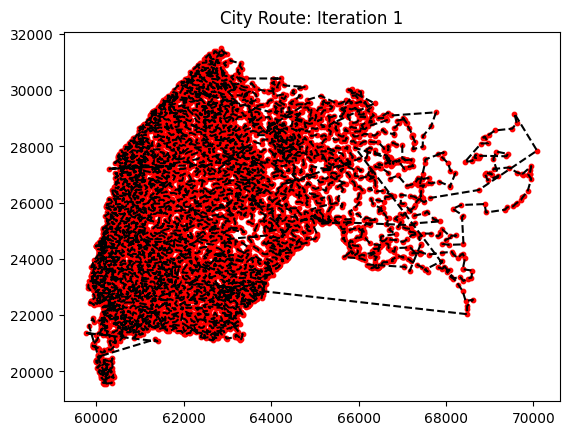

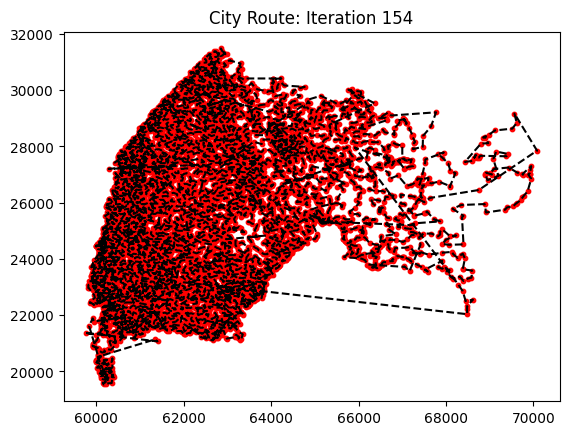

Execution Time: 26.624126195907593
Path: [0, 74, 207, 424, 550, 616, 683, 684, 739, 777, 778, 779, 836, 686, 617, 685, 682, 932, 931, 1067, 1066, 1065, 930, 980, 1021, 1235, 1236, 1285, 1237, 1157, 1325, 1538, 1721, 1628, 1491, 1492, 1442, 1586, 1587, 1679, 1588, 1493, 1443, 1494, 1539, 1589, 1723, 1724, 1725, 1816, 1817, 1764, 1680, 1630, 1590, 1591, 1542, 1446, 1541, 1540, 1445, 1629, 1815, 1893, 1937, 1975, 1938, 1939, 1894, 1940, 2087, 2220, 2267, 2266, 2348, 2399, 2400, 2349, 2300, 2299, 2350, 2351, 2456, 2455, 2499, 2546, 2592, 2591, 2545, 2454, 2498, 2636, 2678, 2730, 2826, 2776, 2876, 3038, 3139, 3191, 3226, 3263, 3336, 3402, 3403, 3372, 3435, 3404, 3373, 3302, 3141, 3089, 2995, 3140, 3264, 3371, 3401, 3370, 3335, 3334, 3300, 3225, 3189, 3224, 3262, 3299, 3190, 3138, 3037, 2994, 2875, 2874, 2993, 2992, 3036, 3088, 2922, 2825, 2873, 2991, 2775, 2728, 2676, 2634, 2541, 2495, 2494, 2493, 2540, 2492, 2450, 2395, 2396, 2342, 2343, 2344, 2345, 2346, 2397, 2452, 2453, 2398, 2347, 2298

In [127]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

In [1]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

In [2]:
# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

## Data Loading

In [3]:
def fileloader():
    with open(file_path, "r") as file:
        file_str = file.readlines()
    
    coord_start_idx = 8
    for line in range(2,len(file_str)-1):
        if 'NODE_COORD_SECTION' in file_str[line]:
            coord_start_idx = line + 1
    # Get the coordinates of cities
    coord_str = file_str[coord_start_idx:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = float(items[1]), float(items[2])

    return coord_list

In [4]:
file_path = 'fi10639.tsp'

# 

In [5]:
# First City Index
FIRST_IDX = 0

## GA

In [13]:
# Global Variables
# GA
POOL_SIZE = 20 
TOURNAMENT_SIZE = 5
MAX_ITERATION = 100000

# SA
### modified due to time constraint ###
MAX_EVALUATION = 50
SUB_ITERATIONS = 10
TEMPERATURE = 50
COOLING_RATIO = 0.3
TEMP_LIMIT = 1

In [14]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

In [15]:
def two_opt_swap(path_map, path, iterations, coord_list):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    for i in range(iterations):
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost
    
    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO 
    return best_path, best_cost

In [16]:
def sa(path_map, path, coord_list):
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()

    for i in range(MAX_EVALUATION):
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost
            
    return best_path, best_cost

In [17]:
def initialization(coord_list):
    cnt_cities = len(coord_list)
    path_pool = np.zeros((POOL_SIZE, cnt_cities + 1), dtype=np.int32)
    pool_cost = np.zeros(POOL_SIZE)
    
    path_map, path_pool[0, :] = initialize_greedy(coord_list, FIRST_IDX)
    pool_cost[0] = path_cost(path_map, path_pool[0, :]).sum()

    print('Path {} is initialized'.format(0))

    for i in range(1, POOL_SIZE):
        _, path_pool[i, :] = initialize_random(coord_list, FIRST_IDX)
        path_pool[i, :], pool_cost[i] = sa(path_map, path_pool[i, :], coord_list)
        print('Path {} is initialized'.format(i))
    
    return path_pool, pool_cost, path_map

In [18]:
def selection(pool_cost, TOURNAMENT_SIZE, sel_size=2):
    # tournament selection
    sel_idx = np.random.choice(POOL_SIZE, TOURNAMENT_SIZE, replace=False)
    sel_cost = pool_cost[sel_idx]
    best_idx = sel_idx[np.argsort(sel_cost)][:sel_size]
    return best_idx

In [19]:
def crossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Initialize child path
    child_path = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path[0], child_path[-1] = -1, -1
    # Copy the path between crossover points
    child_path[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    # Copy the rest of the path from path2
    path2_idx = np.where(np.isin(path2, child_path) == False)[0]
    child_path[np.where(child_path == 0)[0]] = path2[path2_idx]
    child_path[0], child_path[-1] = FIRST_IDX, FIRST_IDX

    return child_path


In [20]:
# swap mutation
def mutation(path):
    cnt_cities = len(path)
    child_path = path.copy()
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])

    return child_path 


In [21]:
# genetic algorithm
def ga(coord_list):
    
    ga_start_time = time.time()
    
    best_cost = np.Inf
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    
    for i in range(MAX_ITERATION):
        
        ### add time limit ###
        if time.time() - ga_start_time >= 58:
            break
        
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        # crossover
        child_crx = crossover(path_pool[sel_idx[0]], path_pool[sel_idx[1]])
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # mutation
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1)
        child_mut = mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)

        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx 
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut 

        cur_idx = np.argmin(pool_cost)
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]

        if best_cost > cur_cost:
            best_cost = cur_cost
            if PLOT_MODE:
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx]

Start Genetic Algorithm
Initialize the population
Path 0 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 1 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 2 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 3 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 4 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 5 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 6 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 7 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 8 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 9 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 10 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 11 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 12 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 13 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 14 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 15 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 16 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 17 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 18 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 19 is initialized
Start the evolution


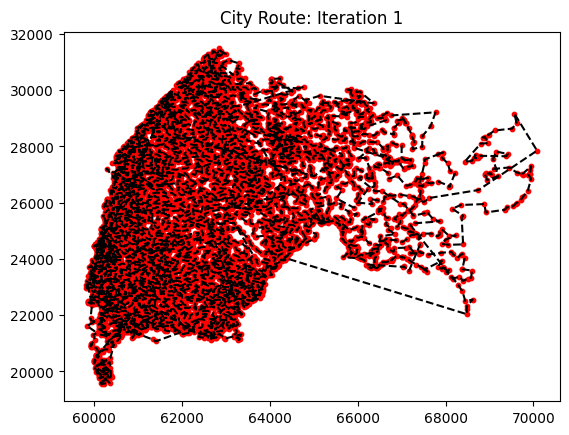

Iteration 1000
Iteration 2000


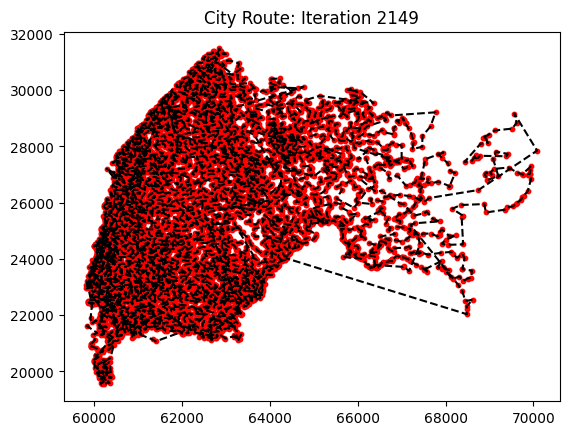

Execution Time: 58.00658583641052
Path: [0, 3, 35, 52, 66, 65, 64, 63, 34, 51, 75, 74, 116, 143, 117, 176, 211, 292, 291, 385, 496, 631, 694, 746, 747, 792, 843, 947, 993, 900, 946, 1034, 945, 791, 745, 629, 630, 562, 495, 384, 290, 289, 333, 383, 493, 560, 627, 628, 561, 494, 252, 210, 175, 142, 141, 174, 115, 209, 251, 250, 288, 332, 380, 381, 382, 433, 492, 626, 692, 693, 744, 790, 842, 841, 898, 897, 944, 943, 990, 1031, 1078, 1030, 989, 942, 941, 895, 838, 894, 893, 940, 988, 1029, 1076, 1028, 987, 1027, 1026, 986, 1025, 1119, 1120, 1165, 1166, 1167, 1247, 1246, 1248, 1291, 1292, 1293, 1332, 1249, 1169, 1168, 1077, 1170, 1171, 1204, 1294, 1295, 1250, 1205, 1173, 1172, 1121, 1079, 1032, 992, 991, 840, 896, 839, 743, 625, 559, 490, 491, 432, 331, 249, 287, 286, 248, 208, 172, 207, 285, 379, 624, 742, 892, 891, 939, 938, 985, 984, 937, 890, 889, 888, 936, 983, 982, 1024, 1070, 1114, 1159, 1160, 1161, 1162, 1115, 1071, 1116, 1163, 1202, 1243, 1290, 1242, 1201, 1241, 1289, 1288, 1368, 

In [22]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))